# Import

In [ ]:
%pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
import string
import numpy as np
import pandas as pd
from io import StringIO
import requests
import csv

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, SpatialDropout1D, Dropout, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# Loading Dataset

In [ ]:
df_reviews = pd.read_csv('tokopedia_30k_reviews.csv', encoding='utf-8')

print(df_reviews)

                                                  Review
0      Aku sudah suka sama tokopedia dari duluuu, sem...
1      Untuk pengembang, tolong yang sistem "BEBAS ON...
2      Saran - selagi masih dengan JNE yang banyak ke...
3      UI/UX bagusan sebelum nya. Wishlist taruh di n...
4      Kecewa sekali. Baru pertama kali daftar dan ni...
...                                                  ...
29995  Saya beli kebutuhan anak di Tokopedia, tetapi ...
29996  Lama tidak belanja , giliran mau belanja akun ...
29997  Suka sering bug. Saat melakukan pencarian bara...
29998  Kecewa sih kupon pengguna baru ternyata cuma p...
29999  Sumpah, aku tau pengiriman itu bukan termasuk ...

[30000 rows x 1 columns]


In [ ]:
total_nan = df_reviews.isna().sum().sum()

print(f"Total nilai NaN di DataFrame: {total_nan}")

Total nilai NaN di DataFrame: 0


# Preprocessing Text

In [ ]:
def cleaningText(text):
    """
    Membersihkan teks dari elemen yang tidak diinginkan seperti mention, hashtag, angka, dan tanda baca.

    Parameter:
    - text (str): Teks yang akan dibersihkan.

    Return:
    - text (str): Teks yang telah dibersihkan.
    """
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus spasi dari kiri dan kanan teks
    return text

def casefoldingText(text):
    """
    Mengubah semua karakter dalam teks menjadi huruf kecil (lowercase).

    Parameter:
    - text (str): Teks yang akan diubah menjadi huruf kecil.

    Return:
    - text (str): Teks yang telah diubah menjadi huruf kecil.
    """
    text = text.lower()
    return text

def tokenizingText(text):
    """
    Memecah teks menjadi daftar kata atau token.

    Parameter:
    - text (str): Teks yang akan dipecah menjadi token.

    Return:
    - text (list): Daftar token (kata-kata) yang dihasilkan dari pemisahan teks.
    """
    text = word_tokenize(text)
    return text

def filteringText(text):
    """
    Menghapus kata-kata umum (stopwords) yang tidak diperlukan dari teks.

    Parameter:
    - text (list): Daftar kata yang akan difilter dari stopwords.

    Return:
    - text (list): Daftar kata yang telah dibersihkan dari stopwords.
    """
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    """
    Mengubah kata-kata menjadi bentuk dasar (kata akar) dengan menghilangkan imbuhan.

    Parameter:
    - text (str): Teks yang akan diubah ke bentuk dasar.

    Return:
    - stemmed_text (str): Teks yang telah diubah ke bentuk dasar.
    """
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    """
    Menggabungkan daftar kata menjadi kalimat lengkap.

    Parameter:
    - list_words (list): Daftar kata yang akan digabung menjadi kalimat.

    Return:
    - sentence (str): Teks hasil gabungan dari daftar kata menjadi kalimat.
    """
    sentence = ' '.join(word for word in list_words)
    return sentence


In [ ]:
slangwords = {
    "@": "di", "duluuu": "dulu", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"
}


In [ ]:
def fix_slangwords(text):
    """
    Mengganti kata-kata slang dalam teks dengan kata-kata standar sesuai kamus slang.

    Parameters:
    - text (str): Kalimat atau teks yang mengandung kata-kata slang yang perlu diganti.

    Returns:
    - fixed_text (str): Teks hasil transformasi di mana setiap kata slang telah diganti dengan padanan kata standar.
    """
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])  # Mengganti dengan kata standar
        else:
            fixed_words.append(word)  # Menyimpan kata asli jika bukan slang

    fixed_text = ' '.join(fixed_words)  # Menggabungkan kembali kata-kata menjadi kalimat
    return fixed_text


In [ ]:
def preprocess_text(df, text_column):
    """
    Melakukan praproses teks pada kolom teks dari DataFrame, termasuk pembersihan teks,
    case folding, perbaikan slang, tokenisasi, filtering stopword, dan penggabungan kembali token.

    Parameters:
    - df (pd.DataFrame): DataFrame yang berisi kolom teks asli untuk diproses.
    - text_column (str): Nama kolom di DataFrame yang berisi teks asli.

    Returns:
    - pd.DataFrame: DataFrame yang sama dengan kolom tambahan untuk setiap langkah praproses.
    """

    # Membersihkan teks
    df['text_clean'] = df[text_column].apply(cleaningText)

    # Mengubah teks menjadi huruf kecil
    df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

    # Mengganti kata slang dengan kata standar
    df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

    # Memecah teks menjadi token
    df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

    # Menghapus kata-kata stopword
    df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

    # Menggabungkan token kembali menjadi kalimat
    df['text_akhir'] = df['text_stopword'].apply(toSentence)

    return df

df_reviews = preprocess_text(df_reviews, 'Review')

In [ ]:
df_reviews

,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,"Aku sudah suka sama tokopedia dari duluuu, sem...",Aku sudah suka sama tokopedia dari duluuu semu...,aku sudah suka sama tokopedia dari duluuu semu...,aku sudah suka sama tokopedia dari dulu semua ...,"[aku, sudah, suka, sama, tokopedia, dari, dulu...","[suka, tokopedia, bagus, ui, appnya, kadang, p...",suka tokopedia bagus ui appnya kadang pencet t...,9,positive
1,"Untuk pengembang, tolong yang sistem ""BEBAS ON...",Untuk pengembang tolong yang sistem BEBAS ONGK...,untuk pengembang tolong yang sistem bebas ongk...,untuk pengembang tolong yang sistem bebas ongk...,"[untuk, pengembang, tolong, yang, sistem, beba...","[pengembang, tolong, sistem, bebas, ongkos, ki...",pengembang tolong sistem bebas ongkos kirim re...,6,positive
2,Saran - selagi masih dengan JNE yang banyak ke...,Saran selagi masih dengan JNE yang banyak kek...,saran selagi masih dengan jne yang banyak kek...,saran selagi masih dengan jne yang banyak keku...,"[saran, selagi, masih, dengan, jne, yang, bany...","[saran, selagi, jne, kekurangannya, update, st...",saran selagi jne kekurangannya update status b...,0,positive
3,UI/UX bagusan sebelum nya. Wishlist taruh di n...,UIUX bagusan sebelum nya Wishlist taruh di nav...,uiux bagusan sebelum nya wishlist taruh di nav...,uiux bagusan sebelum nya wishlist taruh di nav...,"[uiux, bagusan, sebelum, nya, wishlist, taruh,...","[uiux, bagusan, wishlist, taruh, navbar, bagus...",uiux bagusan wishlist taruh navbar bagus niru ...,0,positive
4,Kecewa sekali. Baru pertama kali daftar dan ni...,Kecewa sekali Baru pertama kali daftar dan nia...,kecewa sekali baru pertama kali daftar dan nia...,kecewa sekali baru pertama kali daftar dan nia...,"[kecewa, sekali, baru, pertama, kali, daftar, ...","[kecewa, kali, daftar, niatnya, chekout, first...",kecewa kali daftar niatnya chekout first time ...,-9,negative
...,...,...,...,...,...,...,...,...,...
29995,"Saya beli kebutuhan anak di Tokopedia, tetapi ...",Saya beli kebutuhan anak di Tokopedia tetapi D...,saya beli kebutuhan anak di tokopedia tetapi d...,saya beli kebutuhan anak di tokopedia tetapi d...,"[saya, beli, kebutuhan, anak, di, tokopedia, t...","[beli, kebutuhan, anak, tokopedia, dibatalkan,...",beli kebutuhan anak tokopedia dibatalkan siste...,5,positive
29996,"Lama tidak belanja , giliran mau belanja akun ...",Lama tidak belanja giliran mau belanja akun k...,lama tidak belanja giliran mau belanja akun k...,lama tidak belanja giliran mau belanja akun ke...,"[lama, tidak, belanja, giliran, mau, belanja, ...","[belanja, giliran, belanja, akun, kena, pelang...",belanja giliran belanja akun kena pelanggranhe...,-32,negative
29997,Suka sering bug. Saat melakukan pencarian bara...,Suka sering bug Saat melakukan pencarian baran...,suka sering bug saat melakukan pencarian baran...,suka sering bug saat melakukan pencarian baran...,"[suka, sering, bug, saat, melakukan, pencarian...","[suka, bug, pencarian, barang, toko, barangnya...",suka bug pencarian barang toko barangnya perja...,10,positive
29998,Kecewa sih kupon pengguna baru ternyata cuma p...,Kecewa sih kupon pengguna baru ternyata cuma p...,kecewa sih kupon pengguna baru ternyata cuma p...,kecewa sih kupon pengguna baru ternyata cuma p...,"[kecewa, sih, kupon, pengguna, baru, ternyata,...","[kecewa, kupon, pengguna, penipuan, capek, cap...",kecewa kupon pengguna penipuan capek capek bay...,-7,negative


# Categorize the data

In [ ]:
def load_lexicon(url):
    """
    Mengambil dan membaca data kamus kata-kata dari URL GitHub.

    Parameters:
    - url (str): Alamat URL dari file CSV di GitHub yang berisi data kata-kata beserta nilainya.

    Returns:
    - lexicon (dict): Kamus yang berisi kata sebagai kunci dan nilai sebagai nilainya (misalnya, 1 untuk positif, -1 untuk negatif).
    """
    lexicon = {}
    response = requests.get(url)
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon[row[0]] = int(row[1])
    return lexicon

# Mengambil data positif dan negatif
lexicon_positive = load_lexicon('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
lexicon_negative = load_lexicon('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')


In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
    """
    Menentukan polaritas sentimen dari sebuah teks dalam Bahasa Indonesia berdasarkan kata-kata positif dan negatif.

    Parameters:
    - text (list): Daftar kata-kata yang telah diproses (misalnya, dihapus stopwords atau distem) dari kalimat yang ingin dianalisis.

    Returns:
    - score (int): Skor total sentimen berdasarkan jumlah kata positif dan negatif dalam teks.
    - polarity (str): Kategori sentimen berdasarkan skor, dapat berupa 'positive', 'negative', atau 'neutral'.
    """
    score = 0

    # Menghitung skor dari kata-kata positif
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]

    # Menghitung skor dari kata-kata negatif
    for word in text:
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Menentukan polaritas berdasarkan skor
    if score >= 0:
        polarity = 'positive'
    elif score <= -7:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity


results = df_reviews['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))

df_reviews['polarity_score'] = results[0]
df_reviews['polarity']       = results[1]

print(df_reviews['polarity'].value_counts())

polarity
negative    12900
positive    11100
neutral      6000
Name: count, dtype: int64


In [ ]:
df_reviews

,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,"Aku sudah suka sama tokopedia dari duluuu, sem...",Aku sudah suka sama tokopedia dari duluuu semu...,aku sudah suka sama tokopedia dari duluuu semu...,aku sudah suka sama tokopedia dari dulu semua ...,"[aku, sudah, suka, sama, tokopedia, dari, dulu...","[suka, tokopedia, bagus, ui, appnya, kadang, p...",suka tokopedia bagus ui appnya kadang pencet t...,9,positive
1,"Untuk pengembang, tolong yang sistem ""BEBAS ON...",Untuk pengembang tolong yang sistem BEBAS ONGK...,untuk pengembang tolong yang sistem bebas ongk...,untuk pengembang tolong yang sistem bebas ongk...,"[untuk, pengembang, tolong, yang, sistem, beba...","[pengembang, tolong, sistem, bebas, ongkos, ki...",pengembang tolong sistem bebas ongkos kirim re...,6,positive
2,Saran - selagi masih dengan JNE yang banyak ke...,Saran selagi masih dengan JNE yang banyak kek...,saran selagi masih dengan jne yang banyak kek...,saran selagi masih dengan jne yang banyak keku...,"[saran, selagi, masih, dengan, jne, yang, bany...","[saran, selagi, jne, kekurangannya, update, st...",saran selagi jne kekurangannya update status b...,0,positive
3,UI/UX bagusan sebelum nya. Wishlist taruh di n...,UIUX bagusan sebelum nya Wishlist taruh di nav...,uiux bagusan sebelum nya wishlist taruh di nav...,uiux bagusan sebelum nya wishlist taruh di nav...,"[uiux, bagusan, sebelum, nya, wishlist, taruh,...","[uiux, bagusan, wishlist, taruh, navbar, bagus...",uiux bagusan wishlist taruh navbar bagus niru ...,0,positive
4,Kecewa sekali. Baru pertama kali daftar dan ni...,Kecewa sekali Baru pertama kali daftar dan nia...,kecewa sekali baru pertama kali daftar dan nia...,kecewa sekali baru pertama kali daftar dan nia...,"[kecewa, sekali, baru, pertama, kali, daftar, ...","[kecewa, kali, daftar, niatnya, chekout, first...",kecewa kali daftar niatnya chekout first time ...,-9,negative
...,...,...,...,...,...,...,...,...,...
29995,"Saya beli kebutuhan anak di Tokopedia, tetapi ...",Saya beli kebutuhan anak di Tokopedia tetapi D...,saya beli kebutuhan anak di tokopedia tetapi d...,saya beli kebutuhan anak di tokopedia tetapi d...,"[saya, beli, kebutuhan, anak, di, tokopedia, t...","[beli, kebutuhan, anak, tokopedia, dibatalkan,...",beli kebutuhan anak tokopedia dibatalkan siste...,5,positive
29996,"Lama tidak belanja , giliran mau belanja akun ...",Lama tidak belanja giliran mau belanja akun k...,lama tidak belanja giliran mau belanja akun k...,lama tidak belanja giliran mau belanja akun ke...,"[lama, tidak, belanja, giliran, mau, belanja, ...","[belanja, giliran, belanja, akun, kena, pelang...",belanja giliran belanja akun kena pelanggranhe...,-32,negative
29997,Suka sering bug. Saat melakukan pencarian bara...,Suka sering bug Saat melakukan pencarian baran...,suka sering bug saat melakukan pencarian baran...,suka sering bug saat melakukan pencarian baran...,"[suka, sering, bug, saat, melakukan, pencarian...","[suka, bug, pencarian, barang, toko, barangnya...",suka bug pencarian barang toko barangnya perja...,10,positive
29998,Kecewa sih kupon pengguna baru ternyata cuma p...,Kecewa sih kupon pengguna baru ternyata cuma p...,kecewa sih kupon pengguna baru ternyata cuma p...,kecewa sih kupon pengguna baru ternyata cuma p...,"[kecewa, sih, kupon, pengguna, baru, ternyata,...","[kecewa, kupon, pengguna, penipuan, capek, cap...",kecewa kupon pengguna penipuan capek capek bay...,-7,negative


# Data Exploration

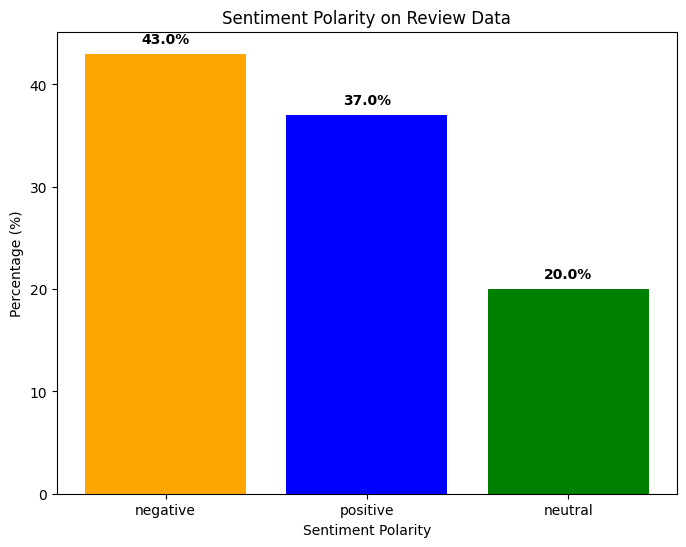

In [ ]:
def plot_sentiment_polarity(df, column_name):
    """
    Membuat diagram batang untuk menampilkan distribusi polaritas sentimen.

    Parameters:
    - df (pd.DataFrame): DataFrame yang berisi data sentimen.
    - column_name (str): Nama kolom dalam DataFrame yang berisi polaritas sentimen.

    Returns:
    - None: Fungsi ini akan menampilkan diagram batang.
    """
    # Menghitung distribusi polaritas dalam persentase
    polarity_counts = df[column_name].value_counts(normalize=True) * 100  # Menghitung persentase

    # Membuat diagram batang
    plt.figure(figsize=(8, 6))
    plt.bar(polarity_counts.index, polarity_counts.values, color=['orange', 'blue', 'green'])
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Percentage (%)')
    plt.title('Sentiment Polarity on Review Data')

    # Menampilkan persentase pada setiap batang
    for i, v in enumerate(polarity_counts.values):
        plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

    plt.show()

plot_sentiment_polarity(df_reviews, 'polarity')

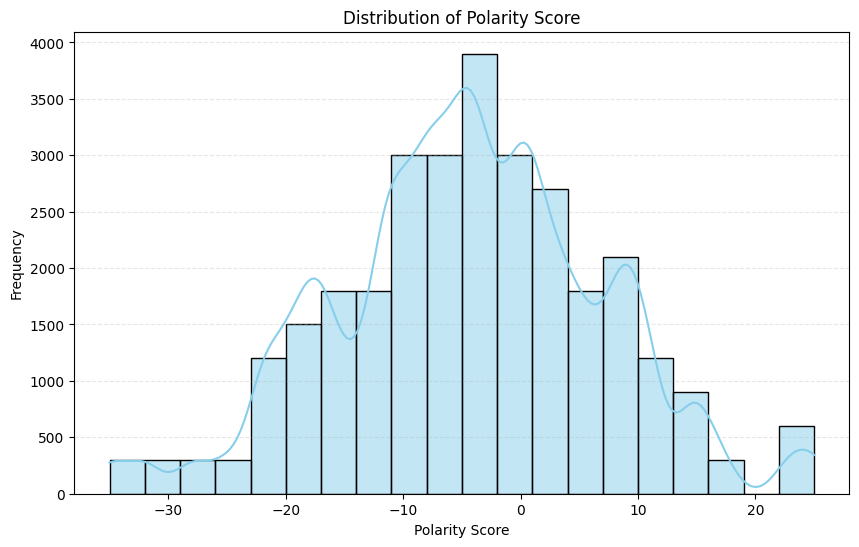

In [ ]:
def plot_polarity_score_distribution(df, score_column):
    """
    Membuat histogram dengan kurva KDE untuk menampilkan distribusi skor polaritas sentimen.

    Parameters:
    - df (pd.DataFrame): DataFrame yang berisi data sentimen.
    - score_column (str): Nama kolom dalam DataFrame yang berisi skor polaritas sentimen.

    Returns:
    - None: Fungsi ini akan menampilkan histogram distribusi skor polaritas dengan kurva KDE.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(df[score_column], bins=20, kde=True, color='skyblue', edgecolor='black')
    plt.xlabel('Polarity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Polarity Score')
    plt.grid(axis='y', linestyle='--', alpha=0.3,)
    plt.show()

plot_polarity_score_distribution(df_reviews, 'polarity_score')


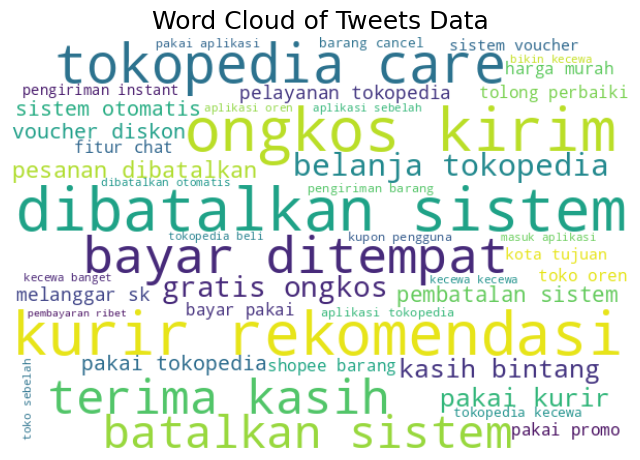

In [ ]:
def generate_wordcloud(data, column_name):
    """
    Membuat Word Cloud dari teks di kolom yang ditentukan.

    Parameters:
    - data (pd.DataFrame): DataFrame yang berisi teks.
    - column_name (str): Nama kolom dalam DataFrame yang berisi teks yang akan digunakan untuk Word Cloud.

    Returns:
    - None: Fungsi ini akan menampilkan Word Cloud.
    """
    # Menggabungkan semua kata dalam kolom yang diberikan menjadi satu string
    list_words = ' '.join([' '.join(tweet) for tweet in data[column_name]])

    # Membuat Word Cloud
    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

    # Menampilkan Word Cloud
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Word Cloud of Tweets Data', fontsize=18)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.show()

generate_wordcloud(df_reviews, 'text_stopword')

In [ ]:
# Mengatur opsi tampilan pandas
pd.set_option('display.max_colwidth', 3000)

def generate_wordcloud_by_polarity(df, polarity_label, column_name):
    """
    Membuat Word Cloud berdasarkan label polaritas tertentu.

    Parameters:
    - df (pd.DataFrame): DataFrame yang berisi data teks dan polaritas.
    - polarity_label (str): Label polaritas yang diinginkan ('positive' atau 'negative').
    - column_name (str): Nama kolom yang berisi teks yang sudah diproses untuk Word Cloud.

    Returns:
    - None: Fungsi ini akan menampilkan Word Cloud berdasarkan label polaritas.
    """
    # Memfilter data berdasarkan polaritas
    selected_tweets = df[df['polarity'] == polarity_label]
    selected_tweets = selected_tweets[['text_akhir', 'polarity_score', 'polarity', column_name]]
    selected_tweets = selected_tweets.sort_values(by='polarity_score', ascending=False).reset_index(drop=True)
    selected_tweets.index += 1  # Menyesuaikan indeks mulai dari 1

    # Menggabungkan semua kata dalam kolom yang diberikan menjadi satu string
    list_words = ' '.join([' '.join(tweet) for tweet in selected_tweets[column_name]])

    # Membuat Word Cloud
    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

    # Menampilkan Word Cloud
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'Word Cloud of {polarity_label.capitalize()} Tweets Data', fontsize=18)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.show()

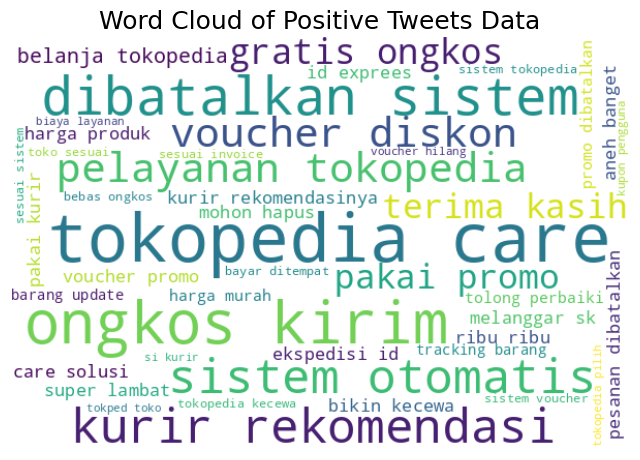

In [ ]:
generate_wordcloud_by_polarity(df_reviews, 'positive', 'text_stopword')

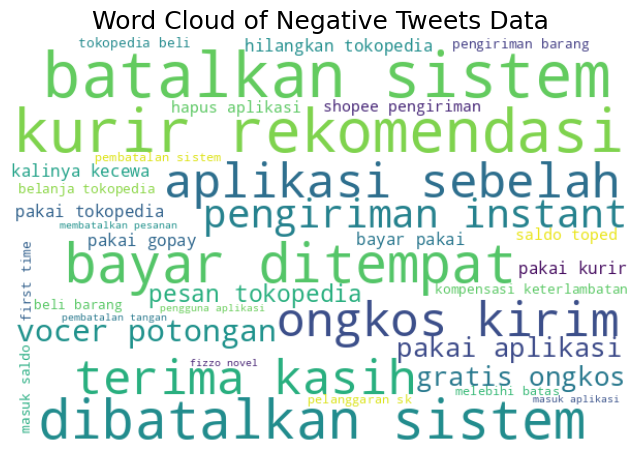

In [ ]:
generate_wordcloud_by_polarity(df_reviews, 'negative', 'text_stopword')

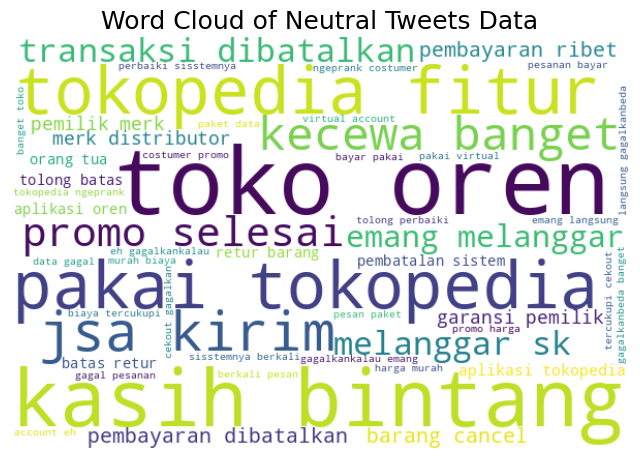

In [ ]:
generate_wordcloud_by_polarity(df_reviews, 'neutral', 'text_stopword')

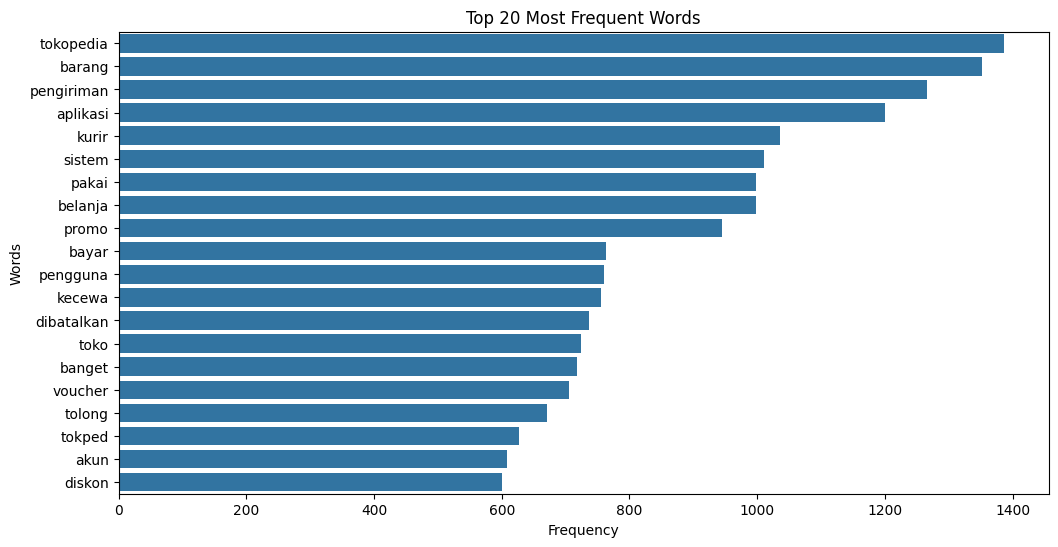

In [ ]:
def plot_most_frequent_words(df, column_name, top_n=20):
    """
    Menampilkan kata-kata yang paling sering muncul dalam kolom teks menggunakan TF-IDF.

    Parameters:
    - df (pd.DataFrame): DataFrame yang berisi teks.
    - column_name (str): Nama kolom dalam DataFrame yang berisi teks yang ingin dianalisis.
    - top_n (int): Jumlah kata yang paling sering muncul untuk ditampilkan (default: 20).

    Returns:
    - None: Fungsi ini akan menampilkan grafik batang dari kata-kata yang paling sering muncul.
    """
    # Mengonversi teks menjadi representasi TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df[column_name])

    # Membuat DataFrame dari hasil TF-IDF
    tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    # Menghitung jumlah kemunculan setiap kata dan mengurutkannya
    tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
    tfidf_df.columns = ['kata', 'jumlah']
    tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(top_n)

    # Membuat grafik batang untuk kata-kata yang paling sering muncul
    plt.figure(figsize=(12, 6))
    sns.barplot(x='jumlah', y='kata', data=tfidf_df)
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

plot_most_frequent_words(df_reviews, 'text_akhir', top_n=20)

# Fitur Extraction

In [132]:
def split_features(df, text_column):
    """
    Memisahkan kolom teks sebagai fitur (X).
    """
    X = df[text_column]
    return X

def tokenize_and_pad_texts(texts, max_features, max_len=None):
    """
    Melakukan tokenisasi dan padding pada teks.
    """
    tokenizer = Tokenizer(num_words=max_features, split=' ')
    tokenizer.fit_on_texts(texts)

    # Mengonversi teks menjadi urutan angka
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    return padded_sequences, tokenizer

# Data Labelling

In [133]:
def split_labels(df, label_column):
    """
    Memisahkan kolom label sebagai label (y).
    """
    y = df[label_column]
    return y

def encode_labels(labels):
    """
    Melakukan encoding pada label (y) menjadi one-hot encoding.
    """
    labelencoder = LabelEncoder()
    integer_encoded = labelencoder.fit_transform(labels)
    one_hot_encoded = to_categorical(integer_encoded)
    return one_hot_encoded, labelencoder

Data Preparation

In [134]:
def prepare_data(df, text_column, label_column, max_features, max_len=None):
    # Bagian Feature Extraction
    X = split_features(df, text_column)
    print("Original Text Data:\n", X.head(), "\n")

    X_processed, tokenizer = tokenize_and_pad_texts(X.values, max_features, max_len)
    print("Tokenized and Padded Texts (X):\n", X_processed[:5], "\n")
    print("Vocabulary Size:", len(tokenizer.word_index), "\n")

    # Bagian Data Labeling
    y = split_labels(df, label_column)
    print("Original Labels:\n", y.head(), "\n")

    y_processed, labelencoder = encode_labels(y)
    print("Encoded Labels (y):\n", y_processed[:5], "\n")

    # Menentukan jumlah kelas
    num_classes = y_processed.shape[1]
    print("Number of Classes:", num_classes, "\n")

    return X_processed, y_processed, tokenizer, labelencoder, num_classes

max_features  = 2500
max_len       = 100  # Panjang maksimal padding, misalnya 100 kata

# Menyiapkan data ('text_akhir' adalah fiturnya dan 'polarity' adalah labelnya)
X, y, tokenizer, labelencoder, num_classes = prepare_data(df_reviews, 'text_akhir', 'polarity', max_features, max_len)

Original Text Data:
 0                                                                                                                                              suka tokopedia bagus ui appnya kadang pencet tombol pencarian klik beberapakali kurir jne terbaik super lambat nasib banget pakai kurir rekomendasi
1                                                                                                                    pengembang tolong sistem bebas ongkos kirim rekomendasi memilih kurirnya otomatis daerah kurirnya beda kota alhasil paket stuck mengambil ok toko online favorit terima kasih
2    saran selagi jne kekurangannya update status barang ditahan sortir barang diantar berharihari berhenti promo bug pas co tiba² hilang promonya penjual kebebasan memberikannya kurir sampainya nb kasih bintang selagi jne memperbaiki aslinya bintang aplikasinya bagus rapi friendly bintang
3                                                                          uiux bagusan wishlist taruh nav

# Modelling

Melakukan tiga percobaan skema pelatihan yang berbeda dan dibedakan dengan variasi dari dua kombinasi seperti berikut:

1. Model 1

*   Algoritma Pelatihan: LSTM
*   Pembagian Data: Training 70, val 20, test 10

2. Model 2

*   Algoritma Pelatihan: GRU
*   Pembagian Data: Training 80, val 10, test 10

3. Model 3

*   Algoritma Pelatihan: RNN
*   Pembagian Data: Training 90, val 5, test 5

In [ ]:
# Callback (berhenti jika nilai akurasi > 0.95)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print(f"\nAkurasi pelatihan dan validasi telah melebihi 0.95, menghentikan pelatihan pada epoch {epoch+1}")
            self.model.stop_training = True

early_stopping = CustomCallback()

## Model 1: LSTM

Note
*   Algoritma Pelatihan: LSTM
*   Pembagian Data: Training 70, val 20, test 10

In [97]:
# Membagi Train + Validation Data dan Test Data
# Memisahkan 10% dari data awal untuk dijadikan test data (X_test dan y_test). Sisanya (90%) akan menjadi train+validation data (X_train_val dan y_train_val)
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)

# Membagi Train Data dan Validation Data dari Train + Validation Data
# Memisahkan train+validation data yang sudah diperoleh (90% data awal) menjadi train data dan validation data.
# Menggunakan 2/9 atau 20 dari 90% data awal dari train+validation data sebagai validation data, yang setara dengan 20% dari data awal
# Ini berarti 70% dari data awal akan menjadi train data, dan 20% akan menjadi validation data.
X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)

# Menampilkan shape data untuk memastikan pemisahan berhasil
print('Train Data Shape: ', X_train_LSTM.shape, y_train_LSTM.shape)
print('Val Data Shape: ', X_val_LSTM.shape, y_val_LSTM.shape)
print('Test Data Shape: ', X_test_LSTM.shape, y_test_LSTM.shape)


Train Data Shape:  (21000, 48) (21000, 3)
Val Data Shape:  (6000, 48) (6000, 3)
Test Data Shape:  (3000, 48) (3000, 3)


In [ ]:
def build_and_train_LSTM(X_train, y_train, X_val, y_val, max_features, num_classes, input_length, early_stopping=None):
    """
    Membangun dan melatih model LSTM dengan parameter yang ditentukan dalam layer Sequential.

    Parameters:
        X_train, y_train, X_val, y_val: Data pelatihan dan validasi
        max_features: Jumlah fitur maksimum untuk layer embedding
        num_classes: Jumlah kelas untuk output layer
        input_length: Panjang input sequence
        early_stopping: Callback EarlyStopping untuk menghentikan pelatihan lebih awal jika validasi tidak membaik

    Returns:
        model: Model LSTM yang telah dilatih
        history: Riwayat pelatihan model
    """

    model = Sequential([
        # Embedding Layer
        Embedding(input_dim=max_features, output_dim=256, input_length=input_length),

        # LSTM Layers
        LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)),

        # Dense Layers
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    # Kompilasi model dengan optimizer Adam
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # Melatih model dengan early stopping jika diberikan
    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=256,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[early_stopping] if early_stopping else None)

    return model, history


model_LSTM, history_LSTM = build_and_train_LSTM(
    X_train_LSTM, y_train_LSTM,
    X_val_LSTM, y_val_LSTM,
    max_features=10000,
    num_classes=3,
    input_length=X_train_LSTM.shape[1],
    early_stopping=early_stopping
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 60s 663ms/step - accuracy: 0.7742 - loss: 3.6907 - val_accuracy: 1.0000 - val_loss: 0.3906
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 1.0000 - loss: 0.2437
Akurasi pelatihan dan validasi telah melebihi 0.95, menghentikan pelatihan pada epoch 2
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 670ms/step - accuracy: 1.0000 - loss: 0.2427 - val_accuracy: 1.0000 - val_loss: 0.0476


In [142]:
# Evaluasi model
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=1)
print("Test score: %.2f" % (score_LSTM))
print("Test accuracy: %.2f" % (acc_LSTM))

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 1.0000 - loss: 0.0475
Test score: 0.05
Test accuracy: 1.00


In [135]:
# Evaluasi model pada train set
score_train, acc_train = model_LSTM.evaluate(X_train_LSTM, y_train_LSTM, verbose=1)
print("Train score: %.2f" % (score_train))
print("Train accuracy: %.2f" % (acc_train))

# Evaluasi model pada validation set
score_val, acc_val = model_LSTM.evaluate(X_val_LSTM, y_val_LSTM, verbose=1)
print("Validation score: %.2f" % (score_val))
print("Validation accuracy: %.2f" % (acc_val))

# Evaluasi model pada test set
score_test, acc_test = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=1)
print("Test score: %.2f" % (score_test))
print("Test accuracy: %.2f" % (acc_test))


657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 1.0000 - loss: 0.0476
Train score: 0.05
Train accuracy: 1.00
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 1.0000 - loss: 0.0476
Validation score: 0.05
Validation accuracy: 1.00
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 1.0000 - loss: 0.0475
Test score: 0.05
Test accuracy: 1.00


Akurasi pada training set dan testing set di atas 92%. ✅

In [94]:
model_LSTM.save('model_LSTM.h5')

## Model 2: GRU

Note
*   Algoritma Pelatihan: GRU
*   Pembagian Data: Training 80, val 10, test 10

In [99]:
# Membagi Train + Validation Data dan Test Data
# Memisahkan 10% dari data awal untuk dijadikan test data (X_test_GRU dan y_test_GRU). Sisanya (90%) akan menjadi train+validation data (X_train_val dan y_train_val).
X_train_val, X_test_GRU, y_train_val, y_test_GRU = train_test_split(X, y, test_size=0.1, random_state=42)

# Membagi Train Data dan Validation Data dari Train + Validation Data
# Memisahkan train+validation data yang sudah diperoleh (90% data awal) menjadi train data dan validation data.
# Menggunakan 1/9 dari train+validation data sebagai validation data, yang setara dengan 10% dari data awal.
# Ini berarti 80% dari data awal akan menjadi train data, dan 10% akan menjadi validation data.
X_train_GRU, X_val_GRU, y_train_GRU, y_val_GRU = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

# Menampilkan shape data untuk memastikan pemisahan berhasil
print('Train Data Shape: ', X_train_GRU.shape, y_train_GRU.shape)
print('Validation Data Shape: ', X_val_GRU.shape, y_val_GRU.shape)
print('Test Data Shape: ', X_test_GRU.shape, y_test_GRU.shape)


Train Data Shape:  (24000, 48) (24000, 3)
Validation Data Shape:  (3000, 48) (3000, 3)
Test Data Shape:  (3000, 48) (3000, 3)


In [102]:
def build_and_train_GRU(X_train, y_train, X_val, y_val, max_features, num_classes, input_length, early_stopping=None):
    """
    Membangun dan melatih model GRU dengan parameter yang ditentukan dalam layer Sequential.

    Parameters:
        X_train, y_train, X_val, y_val: Data train dan validation
        max_features: Jumlah fitur maksimum untuk layer embedding
        num_classes: Jumlah kelas untuk output layer
        input_length: Panjang input sequence
        early_stopping: Callback EarlyStopping untuk menghentikan pelatihan lebih awal jika validasi tidak membaik

    Returns:
        model: Model GRU yang telah dilatih
        history: Riwayat pelatihan model
    """
    # Membangun model GRU
    model = Sequential([
        # Embedding Layer
        Embedding(input_dim=max_features, output_dim=512, input_length=input_length),

        # Spatial Dropout Layer
        SpatialDropout1D(0.3),

        # Bidirectional GRU Layers
        Bidirectional(GRU(64, return_sequences=True)),
        Bidirectional(GRU(128, return_sequences=False)),

        # Dense Layers with Dropout and Regularization
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    # Kompilasi model dengan optimizer Adam
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # Melatih model dengan early stopping jika diberikan
    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=256,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[early_stopping] if early_stopping else None)

    return model, history

# Pemanggilan fungsi untuk melatih model GRU
model_GRU, history_GRU = build_and_train_GRU(
    X_train_GRU, y_train_GRU,
    X_val_GRU, y_val_GRU,
    max_features=10000,
    num_classes=3,
    input_length=X_train_GRU.shape[1],
    early_stopping=early_stopping
)


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7106 - loss: 2.2914 - val_accuracy: 1.0000 - val_loss: 0.3643
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9998 - loss: 0.2534
Akurasi pelatihan dan validasi telah melebihi 0.95, menghentikan pelatihan pada epoch 2
94/94 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9998 - loss: 0.2525 - val_accuracy: 1.0000 - val_loss: 0.0647


In [143]:
# Evaluasi model GRU pada test set
score_GRU, acc_GRU = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=1)

print("Test score (GRU): %.2f" % (score_GRU))
print("Test accuracy (GRU): %.2f" % (acc_GRU))

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 1.0000 - loss: 0.0647
Test score (GRU): 0.06
Test accuracy (GRU): 1.00


In [136]:
# Evaluasi model pada train set
score_train, acc_train = model_GRU.evaluate(X_train_GRU, y_train_GRU, verbose=1)
print("Train score: %.2f" % (score_train))
print("Train accuracy: %.2f" % (acc_train))

# Evaluasi model pada validation set
score_val, acc_val = model_GRU.evaluate(X_val_GRU, y_val_GRU, verbose=1)
print("Validation score: %.2f" % (score_val))
print("Validation accuracy: %.2f" % (acc_val))

# Evaluasi model pada test set
score_test, acc_test = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=1)
print("Test score: %.2f" % (score_test))
print("Test accuracy: %.2f" % (acc_test))


750/750 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - accuracy: 1.0000 - loss: 0.0647
Train score: 0.06
Train accuracy: 1.00
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 1.0000 - loss: 0.0647
Validation score: 0.06
Validation accuracy: 1.00
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 1.0000 - loss: 0.0647
Test score: 0.06
Test accuracy: 1.00


Akurasi pada training set dan testing set di atas 92%. ✅

In [105]:
model_GRU.save('model_GRU.h5')

## Model 3: RNN

Note
*   Algoritma Pelatihan: RNN
*   Pembagian Data: Training 90, val 5, test 5

In [106]:
# Membagi Train + Validation Data dan Test Data
# Memisahkan 5% dari data awal untuk dijadikan test data (X_test_RNN dan y_test_RNN). Sisanya (95%) akan menjadi train+validation data (X_train_val dan y_train_val).
X_train_val, X_test_RNN, y_train_val, y_test_RNN = train_test_split(X, y, test_size=0.05, random_state=42)

# Membagi Train Data dan Validation Data dari Train + Validation Data
# Memisahkan train+validation data yang sudah diperoleh (95% data awal) menjadi train data dan validation data.
# Menggunakan 1/19 dari train+validation data sebagai validation data, yang setara dengan 5% dari data awal.
# Ini berarti 90% dari data awal akan menjadi train data, dan 5% akan menjadi validation data.
X_train_RNN, X_val_RNN, y_train_RNN, y_val_RNN = train_test_split(X_train_val, y_train_val, test_size=1/19, random_state=42)

# Menampilkan shape data untuk memastikan pemisahan berhasil
print('Train Data Shape: ', X_train_RNN.shape, y_train_RNN.shape)
print('Validation Data Shape: ', X_val_RNN.shape, y_val_RNN.shape)
print('Test Data Shape: ', X_test_RNN.shape, y_test_RNN.shape)


Train Data Shape:  (27000, 48) (27000, 3)
Validation Data Shape:  (1500, 48) (1500, 3)
Test Data Shape:  (1500, 48) (1500, 3)


In [109]:
def build_and_train_RNN(X_train, y_train, X_val, y_val, max_features, num_classes, input_length, early_stopping=None):
    """
    Membangun dan melatih model RNN dengan parameter yang ditentukan dalam layer Sequential.

    Parameters:
        X_train, y_train, X_val, y_val: Data train dan validation
        max_features: Jumlah fitur maksimum untuk layer embedding
        num_classes: Jumlah kelas untuk output layer
        input_length: Panjang input sequence
        early_stopping: Callback EarlyStopping untuk menghentikan pelatihan lebih awal jika validasi tidak membaik

    Returns:
        model: Model RNN yang telah dilatih
        history: Riwayat pelatihan model
    """

    model = Sequential([
        # Embedding Layer
        Embedding(input_dim=max_features, output_dim=256, input_length=input_length),

        # RNN Layers
        SimpleRNN(128, dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True),
        SimpleRNN(64, dropout=0.2, kernel_regularizer=l2(0.01)),

        # Dense Layers
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    # Kompilasi model dengan optimizer Adam
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # Melatih model dengan early stopping jika diberikan
    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=256,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[early_stopping] if early_stopping else None)

    return model, history

# Pemanggilan fungsi untuk melatih model RNN
model_RNN, history_RNN = build_and_train_RNN(
    X_train_RNN, y_train_RNN,
    X_val_RNN, y_val_RNN,
    max_features=10000,
    num_classes=3,
    input_length=X_train_RNN.shape[1],
    early_stopping=early_stopping
)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9272 - loss: 1.8748
Akurasi pelatihan dan validasi telah melebihi 0.95, menghentikan pelatihan pada epoch 1
106/106 ━━━━━━━━━━━━━━━━━━━━ 74s 258ms/step - accuracy: 0.9278 - loss: 1.8674 - val_accuracy: 1.0000 - val_loss: 0.2030


In [144]:
# Evaluasi model RNN pada test set
score_RNN, acc_RNN = model_RNN.evaluate(X_test_RNN, y_test_RNN, verbose=1)

print("Test score (RNN): %.2f" % (score_RNN))
print("Test accuracy (RNN): %.2f" % (acc_RNN))

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.2029
Test score (RNN): 0.20
Test accuracy (RNN): 1.00


In [137]:
# Evaluasi model pada train set
score_train, acc_train = model_RNN.evaluate(X_train_RNN, y_train_RNN, verbose=1)
print("Train score: %.2f" % (score_train))
print("Train accuracy: %.2f" % (acc_train))

# Evaluasi model pada validation set
score_val, acc_val = model_RNN.evaluate(X_val_RNN, y_val_RNN, verbose=1)
print("Validation score: %.2f" % (score_val))
print("Validation accuracy: %.2f" % (acc_val))

# Evaluasi model pada test set
score_test, acc_test = model_RNN.evaluate(X_test_RNN, y_test_RNN, verbose=1)
print("Test score: %.2f" % (score_test))
print("Test accuracy: %.2f" % (acc_test))


844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 1.0000 - loss: 0.2029
Train score: 0.20
Train accuracy: 1.00
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.2030
Validation score: 0.20
Validation accuracy: 1.00
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.2029
Test score: 0.20
Test accuracy: 1.00


Akurasi pada training set dan testing set di atas 92%. ✅

In [111]:
model_RNN.save('model_RNN.h5')

# Compare Model

In [112]:
results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'RNN'],
    'Accuracy Train': [history_LSTM.history['accuracy'][-1], history_GRU.history['accuracy'][-1],history_RNN.history['accuracy'][-1]],
    'Accuracy Test': [acc_LSTM, acc_GRU, acc_RNN]
})

results_df

,Model,Accuracy Train,Accuracy Test
0,LSTM,0.999905,1.0
1,GRU,0.999833,1.0
2,RNN,0.982407,1.0


In [126]:
def predict_text_labels(new_reviews, true_labels, models, tokenizer, labelencoder, max_len):
    """
    Memprediksi label untuk teks baru menggunakan model yang diberikan dan menampilkan hasil prediksi.

    Parameters:
        new_reviews (list of str): Daftar teks baru yang akan diprediksi.
        true_labels (list of str): Label sebenarnya dari teks baru.
        models (dict): Dictionary berisi model untuk prediksi, seperti {'LSTM': model_LSTM, 'GRU': model_GRU, 'RNN': model_RNN}.
        tokenizer: Tokenizer yang digunakan untuk mempersiapkan data teks.
        labelencoder: Label encoder untuk mengonversi label numerik menjadi label teks.
        max_len (int): Panjang maksimum dari sequence input.
    """
    # Tokenisasi teks baru
    new_sequences = tokenizer.texts_to_sequences(new_reviews)
    new_padded_sequences = pad_sequences(new_sequences, maxlen=max_len)

    # Membuat prediksi untuk setiap model
    predictions = {name: model.predict(new_padded_sequences) for name, model in models.items()}

    # Mengubah prediksi menjadi label
    predicted_labels = {name: labelencoder.inverse_transform(np.argmax(pred, axis=1)) for name, pred in predictions.items()}

    # Menampilkan hasil prediksi
    for text, true_label in zip(new_reviews, true_labels):
        print(f"Text: {text}\nTrue Label: {true_label}")
        for model_name, labels in predicted_labels.items():
            print(f"Predicted Label ({model_name}): {labels[new_reviews.index(text)]}")
        print("\n")


new_reviews = [
    "Layanan SiCepat benar-benar mengecewakan. Pengiriman barang bisa dikategorikan sangat lambat, dan ini kurang mengenakkan. Sebagai pengguna setia Tokopedia, saya berharap Tokopedia bisa mempertimbangkan ulang kerja dan memperhatian lebih pada layanan kurir yang dapat dipercaya dan menghargai waktu pelanggan",
    "Sangat kecewa dengan layanan Tokopedia akhir-akhir ini. Banyak fitur yang dulunya memudahkan sekarang menjadi terasa lebih sulit, bagusan UI UX yang dulu, dan promo gratis ongkir terasa semakin sulit didapat",
    "Sangat suka dan puas sekali berbelanja di Tokopedia! Produk-produknya lengkap, mulai dari kebutuhan sehari-hari hingga barang elektronik, semuanya ada di sini. Proses pembelian mudah sekali!"
]

true_labels = ["positive", "negative", "neutral"]

models = {'LSTM': model_LSTM, 'GRU': model_GRU, 'RNN': model_RNN}
max_len = X.shape[1]

predict_text_labels(new_reviews, true_labels, models, tokenizer, labelencoder, max_len)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Text: Layanan SiCepat benar-benar mengecewakan. Pengiriman barang bisa dikategorikan sangat lambat, dan ini kurang mengenakkan. Sebagai pengguna setia Tokopedia, saya berharap Tokopedia bisa mempertimbangkan ulang kerja dan memperhatian lebih pada layanan kurir yang dapat dipercaya dan menghargai waktu pelanggan
True Label: positive
Predicted Label (LSTM): neutral
Predicted Label (GRU): positive
Predicted Label (RNN): positive


Text: Sangat kecewa dengan layanan Tokopedia akhir-akhir ini. Banyak fitur yang dulunya memudahkan sekarang menjadi terasa lebih sulit, bagusan UI UX yang dulu, dan promo gratis ongkir terasa semakin sulit didapat
True Label: negative
Predicted Label (LSTM): neutral
Predicted Label (GRU): neutral
Predicted Label (RNN): positive


Text: Sangat suka dan puas sekali berbelanja di Tokopedia! Produk-produknya lengkap, mulai dari kebutuhan sehari-hari hin

In [4]:
!pipreqs --scan-notebooks

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in c:\Users\melli\Dropbox\PC\Downloads\di\Analisis Sentimen\requirements.txt
